# Data Preprocessing

Data pre-processing increases the quality of the data thus making it fit to be analyzed. It minimizes errors, variations, and duplication, hence enhancing the possibility of getting the best predictions.

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset (1).csv
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

First 5 Rows:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.

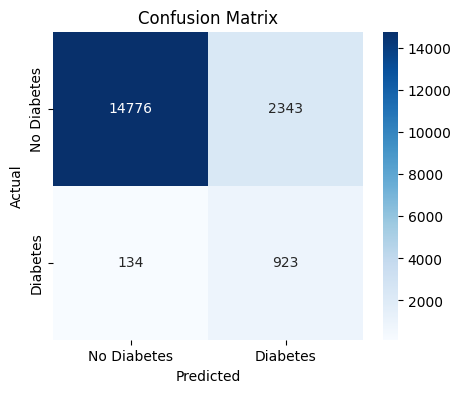

<ipython-input-3-68f29807add0>:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


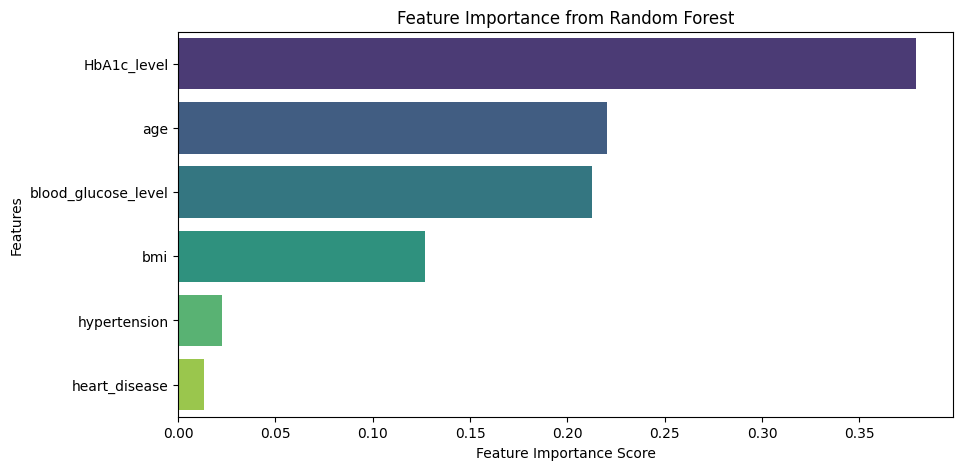

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Upload the dataset manually in Google Colab
from google.colab import files
uploaded = files.upload()

# Step 1: Load and Inspect Dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")

print("Dataset Info:")
print(df.info())

print("\nFirst 5 Rows:")
print(df.head())

# Step 1: Handle Missing Values (HbA1c_level)
df["HbA1c_level"] = df["HbA1c_level"].replace({"???": np.nan, "Unknown": np.nan})
df["HbA1c_level"] = df.groupby("diabetes")["HbA1c_level"].transform(lambda x: x.fillna(x.median()))

# Step 2: Encode Categorical Features
# One-Hot Encoding for Gender and Smoking History
ohe = OneHotEncoder(drop="first")
encoded_features = ohe.fit_transform(df[["gender", "smoking_history"]]).toarray()
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(["gender", "smoking_history"]))
df = df.drop(columns=["gender", "smoking_history"]).join(encoded_df)

# Step 3: Scale Numerical Features
scaler_standard = StandardScaler()
df[["blood_glucose_level", "HbA1c_level"]] = scaler_standard.fit_transform(df[["blood_glucose_level", "HbA1c_level"]])

scaler_minmax = MinMaxScaler()
df[["bmi", "age"]] = scaler_minmax.fit_transform(df[["bmi", "age"]])

# Step 4: Handle Outliers using IQR
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

outlier_cols = ["blood_glucose_level", "bmi", "age"]
for col in outlier_cols:
    df = remove_outliers_iqr(df, col)

# Step 5: Train-Test Split
X = df.drop(columns=["diabetes"])  # Features
y = df["diabetes"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Step 7: Feature Selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Select top important features
selected_features = feature_importances[feature_importances > 0.01].index
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Step 8: Build and Evaluate a Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Display feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances[selected_features], y=selected_features, hue=selected_features, dodge=False, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.legend().remove()
plt.show()
